Ad:Cudi Soyad:Şami Okul Numarası:2012721308 GitHub Repo Bağlantısı:https://github.com/cudi33/CNN_siniflandirma-

## Google Drive Bağlantısı

Bu adımda, oluşturduğum görüntü veri setine Google Drive üzerinden erişebilmek için Google Drive ortamı Colab çalışma alanına bağlanmıştır.  
Bu sayede veri seti ve sonuç dosyaları kalıcı olarak saklanabilmektedir.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Kullanılan Kütüphaneler

Bu bölümde modelin oluşturulması, eğitilmesi ve sonuçların görselleştirilmesi için gerekli olan kütüphaneler içe aktarılmıştır.

- TensorFlow / Keras: CNN mimarisi ve eğitim süreci  
- ImageDataGenerator: Veri artırma (data augmentation)  
- Matplotlib: Eğitim ve doğrulama grafiklerinin çizimi  
- Pandas: Deney sonuçlarının tablo haline getirilmesi  
- OS: Dosya ve klasör işlemleri


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import pandas as pd
import os


## Veri Seti ve Temel Eğitim Parametreleri

Bu adımda veri setinin bulunduğu dizin tanımlanmış ve model eğitimi için temel parametreler belirlenmiştir.

- Görüntü boyutu: 128x128  
- Epoch sayısı: 20  

Veri seti üç sınıftan oluşmaktadır:
- Kaşık  
- Çatal  
- Bıçak


In [ ]:
dataset_path = "/content/drive/MyDrive/dataset"

img_size = (128, 128)
epochs = 20


## Veri Artırma (Data Augmentation)

Modelin genelleme yeteneğini artırmak ve overfitting riskini azaltmak amacıyla eğitim verisine veri artırma teknikleri uygulanmıştır.

Uygulanan işlemler:
- Döndürme (rotation)
- Genişlik ve yükseklik kaydırma (shift)
- Yakınlaştırma (zoom)
- Yatay çevirme (horizontal flip)

Doğrulama verisi ise sadece yeniden ölçeklendirilmiştir.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


## Eğitim ve Doğrulama Verilerinin Hazırlanması

Bu bölümde veri seti, eğitim (%80) ve doğrulama (%20) olarak ikiye ayrılmıştır.  
Keras `flow_from_directory` yapısı kullanılarak görüntüler otomatik olarak sınıflandırılmıştır.

Toplam:
- Eğitim görüntüsü: 173
- Doğrulama görüntüsü: 42


In [ ]:
batch_size = 32

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 173 images belonging to 3 classes.
Found 42 images belonging to 3 classes.


## Geliştirilmiş CNN Mimarisi

Bu fonksiyon, farklı hiperparametre kombinasyonlarını test edebilmek amacıyla parametrik bir CNN mimarisi oluşturmaktadır.

Model yapısı:
- 3 adet Convolution + MaxPooling katmanı
- Fully Connected (Dense) katman
- Dropout ile aşırı öğrenmenin önlenmesi
- Softmax çıkış katmanı (3 sınıf)

Optimizer olarak Adam, kayıp fonksiyonu olarak categorical crossentropy kullanılmıştır.


In [ ]:
def build_cnn(filters=(32, 64, 128), dense_units=128, dropout=0.5, lr=1e-3):
    model = models.Sequential()

    model.add(layers.Conv2D(filters[0], (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(filters[1], (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(filters[2], (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


## Model Eğitimi ve Erken Durdurma (Early Stopping)

Bu fonksiyon modelin eğitimini gerçekleştirmekte ve eğitim sürecini grafiklerle görselleştirmektedir.

Early Stopping kullanılarak:
- Doğrulama kaybı iyileşmediğinde eğitim durdurulmuştur
- En iyi ağırlıklar otomatik olarak geri yüklenmiştir

Bu sayede modelin aşırı öğrenmesi engellenmiştir.


In [ ]:
def train_and_plot(model, title="Model"):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
    ]

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(f"{title} Accuracy")
    plt.legend(["Train", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"{title} Loss")
    plt.legend(["Train", "Validation"])
    plt.show()

    best_val_acc = max(history.history["val_accuracy"])
    return history, best_val_acc


## Deney A – Temel CNN + Veri Artırma

Bu deneyde temel CNN mimarisi veri artırma teknikleri ile eğitilmiştir.

Parametreler:
- Filtreler: 32-64-128
- Öğrenme oranı: 0.001
- Dropout: 0.5
- Dense birim: 128

Bu deney referans (baseline) olarak kullanılmıştır.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 145s 26s/step - accuracy: 0.2962 - loss: 1.5082 - val_accuracy: 0.4048 - val_loss: 1.0869
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3911 - loss: 1.0894 - val_accuracy: 0.4048 - val_loss: 1.0819
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4569 - loss: 1.0802 - val_accuracy: 0.4524 - val_loss: 1.0812
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5165 - loss: 1.0773 - val_accuracy: 0.5000 - val_loss: 1.0498
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5223 - loss: 1.0274 - val_accuracy: 0.6190 - val_loss: 0.9740
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5681 - loss: 0.9975 - val_accuracy: 0.5952 - val_loss: 0.9028
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6034 - loss: 0.9128 - val_accuracy: 0.6429 - val_loss: 0.7922
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5594 - loss: 0.8762 - val_accuracy: 0.6905 - val_loss: 0.7359
Epoch 

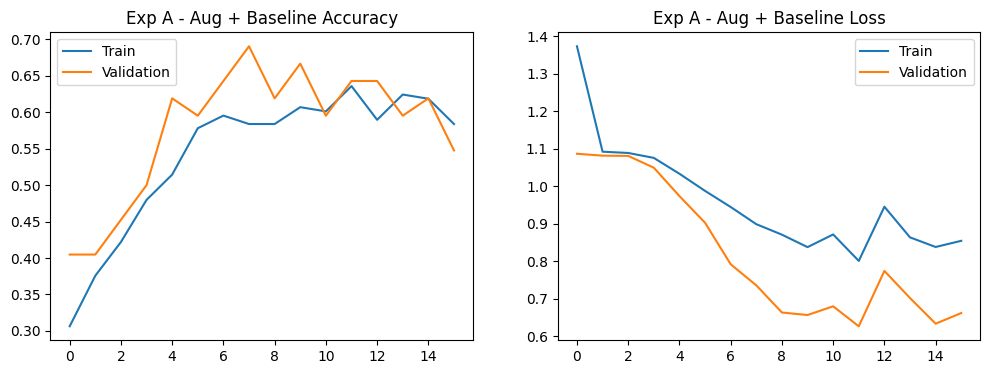

In [ ]:
exp_results = []

model_A = build_cnn(filters=(32,64,128), dense_units=128, dropout=0.5, lr=1e-3)
history_A, best_val_A = train_and_plot(model_A, "Exp A - Aug + Baseline")
exp_results.append(["Exp A", "32-64-128", 32, "1e-3", 0.5, 128, best_val_A])


## Deney B – Daha Derin CNN ve Düşük Öğrenme Oranı

Bu deneyde filtre sayıları artırılmış ve öğrenme oranı düşürülmüştür.

Amaç:
- Daha karmaşık özelliklerin öğrenilmesi
- Daha stabil bir eğitim süreci sağlanması

Bu yapı doğrulama doğruluğunda belirgin bir artış sağlamıştır.


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.3350 - loss: 1.4424 - val_accuracy: 0.4048 - val_loss: 1.0950
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4257 - loss: 1.0912 - val_accuracy: 0.4048 - val_loss: 1.0811
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4091 - loss: 1.0969 - val_accuracy: 0.4048 - val_loss: 1.0827
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4149 - loss: 1.0931 - val_accuracy: 0.4048 - val_loss: 1.0699
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4201 - loss: 1.0902 - val_accuracy: 0.4286 - val_loss: 1.0500
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3689 - loss: 1.0564 - val_accuracy: 0.5238 - val_loss: 0.9968
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5112 - loss: 1.0149 - val_accuracy: 0.5476 - val_loss: 0.9814
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5414 - loss: 0.9454 - val_accuracy: 0.5476 - val_loss: 0.8536
Epoch 9/

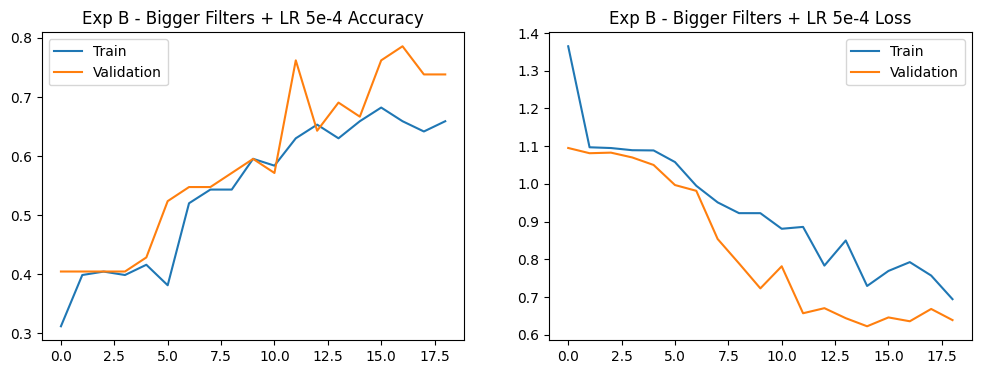

In [ ]:
batch_size = 32
train_gen.batch_size = batch_size

model_B = build_cnn(filters=(64,128,256), dense_units=256, dropout=0.5, lr=5e-4)
history_B, best_val_B = train_and_plot(model_B, "Exp B - Bigger Filters + LR 5e-4")
exp_results.append(["Exp B", "64-128-256", 32, "5e-4", 0.5, 256, best_val_B])


## Deney C – Dropout ve Dense Katman Optimizasyonu

Bu deneyde dropout oranı düşürülmüş ve dense katman birim sayısı artırılmıştır.

Amaç:
- Bilgi kaybını azaltmak
- Daha güçlü temsil öğrenmek

Bu yapı, Model 3 için en dengeli sonuçlardan birini üretmiştir.


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.3531 - loss: 1.1648 - val_accuracy: 0.4048 - val_loss: 1.0812
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5054 - loss: 1.0777 - val_accuracy: 0.4048 - val_loss: 1.0591
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4787 - loss: 1.0461 - val_accuracy: 0.5238 - val_loss: 1.0527
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4889 - loss: 1.0436 - val_accuracy: 0.4286 - val_loss: 0.9833
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5614 - loss: 1.0076 - val_accuracy: 0.5476 - val_loss: 0.9439
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5092 - loss: 0.9937 - val_accuracy: 0.6190 - val_loss: 0.8563
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5576 - loss: 0.9242 - val_accuracy: 0.5714 - val_loss: 0.8026
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6585 - loss: 0.8201 - val_accuracy: 0.6429 - val_loss: 0.7455
Epoch 9/

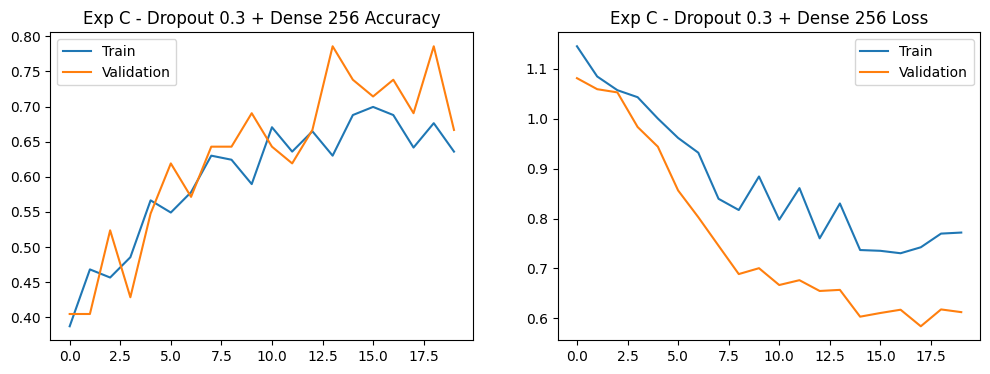

In [ ]:
model_C = build_cnn(filters=(32,64,128), dense_units=256, dropout=0.3, lr=5e-4)
history_C, best_val_C = train_and_plot(model_C, "Exp C - Dropout 0.3 + Dense 256")
exp_results.append(["Exp C", "32-64-128", 32, "5e-4", 0.3, 256, best_val_C])


## Deney Sonuçlarının Karşılaştırılması

Tüm deneyler doğrulama doğruluğu açısından karşılaştırılmış ve sonuçlar tablo haline getirilmiştir.

En yüksek doğrulama doğruluğu veren deney seçilerek en iyi model belirlenmiştir.


In [ ]:
df = pd.DataFrame(exp_results, columns=[
    "Deneme", "Filters", "Batch Size", "LR", "Dropout", "Dense Units", "Best Val Accuracy"
])

df


,Deneme,Filters,Batch Size,LR,Dropout,Dense Units,Best Val Accuracy
0,Exp A,32-64-128,32,1e-3,0.5,128,0.690476
1,Exp B,64-128-256,32,5e-4,0.5,256,0.785714
2,Exp C,32-64-128,32,5e-4,0.3,256,0.785714


In [ ]:
df.to_csv("/content/drive/MyDrive/model3_results.csv", index=False)
print("Saved to Drive: model3_results.csv")


Saved to Drive: model3_results.csv


## En İyi Modelin Belirlenmesi

Deney sonuçlarına göre en yüksek doğrulama doğruluğuna sahip model seçilmiştir.

Sonuçlar göstermektedir ki:
- Veri artırma ve hiperparametre optimizasyonu model performansını artırmıştır
- Model 3, Model 1 ve Model 2’ye kıyasla daha dengeli ve başarılı sonuçlar üretmiştir


In [ ]:
best_row = df.loc[df["Best Val Accuracy"].idxmax()]
best_row


,1
Deneme,Exp B
Filters,64-128-256
Batch Size,32
LR,5e-4
Dropout,0.5
Dense Units,256
Best Val Accuracy,0.785714


Bu bölümde Model2 geliştirilerek Model3 oluşturulmuştur.
Geliştirme sürecinde iki ana yaklaşım uygulanmıştır:

1) Data Augmentation: Eğitim verisi farklı dönüşümler ile çeşitlendirilmiştir
   (rotation, shift, zoom, flip). Bu sayede modelin genelleme yeteneği artırılmıştır.

2) Hiperparametre Denemeleri: Filtre sayıları, öğrenme oranı (LR), dropout oranı ve dense birim sayıları
   farklı kombinasyonlarla test edilmiştir.

Performans tablosu incelendiğinde en yüksek doğrulama başarımına sahip deney seçilmiştir.
Model3'ün doğrulama başarımı Model2’ye göre belirgin şekilde artmıştır / daha stabil hale gelmiştir.
